<a href="https://colab.research.google.com/github/pawara101/notebooks/blob/main/PyTorch/02_pyTorch_nn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN Classification using pytorch
- classification problem


## 01.Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

## Make 100 samples
n_samples = 1000

# Create circle
X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [3]:
print(f"First 5 samples of X : {X[:5]}")
print(f"First 5 samples of y : {y[:5]}")

First 5 samples of X : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y : [1 1 1 1 0]


In [4]:
## Make a Data Frame
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})

circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


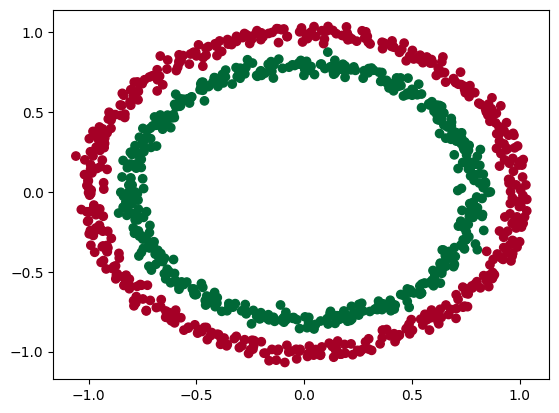

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap="RdYlGn")

In [6]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X : {X_sample} and same for y: {y_sample}")
print(f"Shape for one sample of X : {X_sample.shape} and same for y: {y_sample.shape}")

Values for one sample of X : [0.75424625 0.23148074] and same for y: 1
Shape for one sample of X : (2,) and same for y: ()


## 01.2 Turn data into Tensors

In [7]:
import torch

In [8]:
## Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
## Split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

In [11]:
len(X_train),len(X_test)

(800, 200)

## 02. Building the model
to do this, we want to:
- Setup device
- construct the model using `nn.Module`
- Define a loss function & Optimizer
- Create test & Trainning loop

In [12]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [13]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

### Create model
- create using `nn.Module`
- Create 2 `nn.linear`
- Defines a `forward()`

In [14]:
## Creat subclass method to create the neural network
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    ## Create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  ## Define forward method
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) ## X -> layer_1 -> layer_2 -> Output

## Instantiate and instance of out model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0865,  0.4758],
                      [-0.3780, -0.2833],
                      [ 0.6847,  0.1137],
                      [ 0.0977,  0.3695],
                      [ 0.6684, -0.2546]])),
             ('0.bias', tensor([ 0.2351,  0.0788,  0.2539,  0.5720, -0.6142])),
             ('1.weight',
              tensor([[-0.2097,  0.1649, -0.1823,  0.0082, -0.3033]])),
             ('1.bias', tensor([0.1778]))])

In [17]:
## Make predictions with model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, shape : {untrained_preds.shape}")
print(f"Length of Test samples : {len(X_test)}, shape : {X_test.shape}")

Length of predictions: 200, shape : torch.Size([200, 1])
Length of Test samples : 200, shape : torch.Size([200, 2])


### 2.1 Setup Loss Function and Optimizer
- Use Binary Cross Entropy(BCE)
  - use `torch.nn.BCEWithLogitsLoss()`
  - For a different optimizers see `torch.optim`

In [18]:
## Setup Loss Function
loss_fn = nn.BCEWithLogitsLoss()## BCEWithLogitsLoss = sigmoid built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [19]:
## Calculate Accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100

  return acc


## 3. Train the Model
1. Forward Pass
2. Calculate the Loss
3. Optimizer zero grad
4. Loss Backward(back propagation)
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

- Our Model outputs are going to be raw **logits**
- We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function.
- Then we ccan convert our model's prediction to **predcition labels** by rounding them or taking the

In [20]:
## View the first 5 outputs of teh forward pass on the data
model_0.eval()

with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3796],
        [0.1964],
        [0.5997],
        [0.3183],
        [0.1870]])

In [21]:
## use sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5938],
        [0.5489],
        [0.6456],
        [0.5789],
        [0.5466]])

For prediction probability values, we need to perform a range-style rounding on them:

In [22]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### 3.2 Building the test loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set number of epochs
epochs = 100

# Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)


## Build trainning and evaluation loop
for epoch in range(epochs):
  ## Trainning
  model_0.train()

  # 1.Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2.Calculate loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4.Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### testing
  model_0.eval()

  with torch.inference_mode():
    # 1.Forward pass
    test_logits= model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2.Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    ## print

    if (epoch %10 == 0):
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71354, Accuracy: 53.25% | Test loss: 0.70424, Test acc: 57.00%
Epoch: 10 | Loss: 0.70483, Accuracy: 52.25% | Test loss: 0.69698, Test acc: 51.00%
Epoch: 20 | Loss: 0.70090, Accuracy: 51.25% | Test loss: 0.69401, Test acc: 51.50%
Epoch: 30 | Loss: 0.69882, Accuracy: 50.88% | Test loss: 0.69267, Test acc: 50.00%
Epoch: 40 | Loss: 0.69755, Accuracy: 50.88% | Test loss: 0.69201, Test acc: 50.50%
Epoch: 50 | Loss: 0.69667, Accuracy: 50.38% | Test loss: 0.69167, Test acc: 51.50%
Epoch: 60 | Loss: 0.69601, Accuracy: 50.00% | Test loss: 0.69150, Test acc: 51.50%
Epoch: 70 | Loss: 0.69550, Accuracy: 50.00% | Test loss: 0.69143, Test acc: 52.00%
Epoch: 80 | Loss: 0.69510, Accuracy: 49.88% | Test loss: 0.69142, Test acc: 51.50%
Epoch: 90 | Loss: 0.69477, Accuracy: 50.00% | Test loss: 0.69145, Test acc: 52.00%


## 4. Make Prerdictions and evaluate
 - to inspect make some predictions and visualise them.
 - to do this import `plot.decision`

In [24]:
import requests
from pathlib import Path

##
if Path("helper_functions.py").is_file():
  print("File already exists")

else:
  print("Download helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

Download helper_functions.py


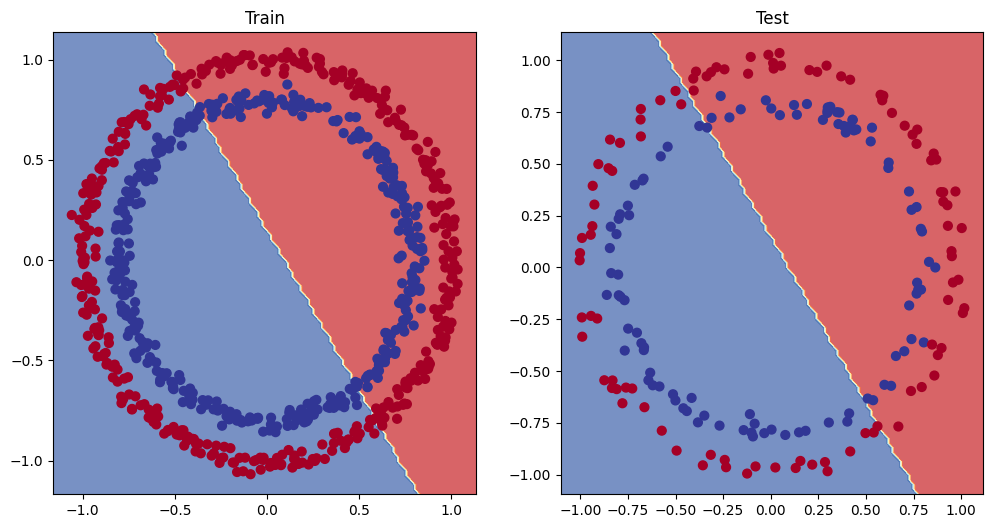

In [25]:
## Plot decision boudary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Imporving a Model
- Add more layers
- Add more hidden layers
- Fit for longer time
- change activation functions
- change learning rate

In [26]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0378,  0.4476],
                      [-0.3545, -0.2710],
                      [ 0.6547,  0.0975],
                      [ 0.0929,  0.3666],
                      [ 0.6255, -0.2777]])),
             ('0.bias', tensor([ 0.2681,  0.0595,  0.2774,  0.5745, -0.5798])),
             ('1.weight',
              tensor([[-0.1687,  0.0260, -0.0475, -0.0072, -0.0903]])),
             ('1.bias', tensor([0.0182]))])